In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('G:/My Drive/Downloads/Ecommerce Customers.txt', delimiter=',')

# change column name for easier access
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(' ', '_') for x in df.columns]
df.columns = [x.replace('.', '') for x in df.columns]
df.columns = [x.replace('\t', '') for x in df.columns]

df = df.rename(columns={'avg_session_length': 'stylist_session',
                        'time_on_app': 'app_duration',
                        'time_on_website': 'web_duration',
                        'length_of_membership': 'membership_duration',
                        'yearly_amount_spent': 'spending'
                       })

# 1. Objectives
- Determine whether customer screen time on website is greater than customer screen time on application.
- Knowing which variables have a linear correlation with `spending`.
- Making predictions with outcome 'spending' and predictor that is most influential and independent.

In [3]:
df.head(1)

,email,address,avatar,stylist_session,app_duration,web_duration,membership_duration,spending
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   email                500 non-null    object 
 1   address              500 non-null    object 
 2   avatar               500 non-null    object 
 3   stylist_session      500 non-null    float64
 4   app_duration         500 non-null    float64
 5   web_duration         500 non-null    float64
 6   membership_duration  500 non-null    float64
 7   spending             500 non-null    float64
dtypes: float64(5), object(3)
memory usage: 31.4+ KB


In [5]:
data = df.iloc[:, 3:]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
stylist_session,500.0,33.053194,0.992563,29.532429,32.341822,33.082008,33.711985,36.139662
app_duration,500.0,12.052488,0.994216,8.508152,11.388153,11.983231,12.753850,15.126994
web_duration,500.0,37.060445,1.010489,33.913847,36.349257,37.069367,37.716432,40.005182
membership_duration,500.0,3.533462,0.999278,0.269901,2.930450,3.533975,4.126502,6.922689
spending,500.0,499.314038,79.314782,256.670582,445.038277,498.887875,549.313828,765.518462


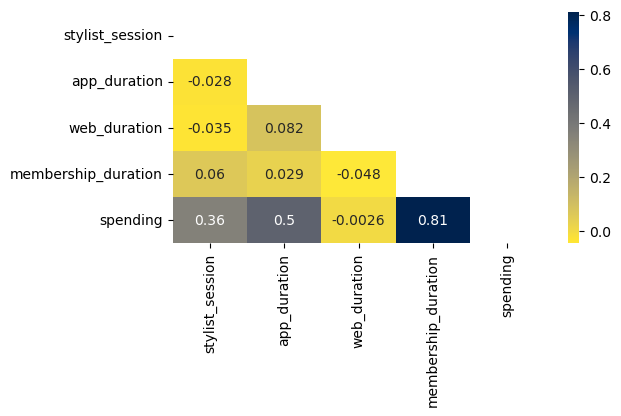

In [6]:
import seaborn as sns

plt.figure(figsize = (6, 3))
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(),
            annot=True,
            mask=mask,
            cmap='cividis_r')
plt.show()

# 2. Statistiacal Test
#### Average time on website is greater than average time on mobile application

- H0 = Average time on Website = Average time on mobile application
- H1 = Average time on Website > Average time on mobile application

## 2.1. Hyphotesis Testing

In [7]:
# variance checking
x1 = data.web_duration
x2 = data.app_duration
x1_mean = x1.mean()
x2_mean = x2.mean()
x1_var = x1.var()
x2_var = x2.var()

# checking if the variance is equal or not
if round(x1_var) == round(x2_var):
    print('Variance time on application: ', round(x1_var))
    print('Variance time one website:', round(x2_var))
    print('Variance equal.')
else:
    print('Variance time on application: ', round(x1_var))
    print('Variance time one website:', round(x2_var))
    print('Varicance not equal.')

Variance time on application:  1
Variance time one website: 1
Variance equal.


In [8]:
# because the variance is equal, I will set the equal_var=True
import scipy.stats as stats

alpha = 0.05
t_stats, p_value = stats.ttest_ind(x1,
                                 x2,
                                 equal_var = True,
                                 alternative = 'greater')

print('t-statistic:', t_stats)
print('p-value:', round(p_value, 2))
print('Significance level:', alpha)

if p_value > alpha:
    print(f'\nResult: Fail to reject H0')
else:
    print(f'\nResult: Reject H0')

t-statistic: 394.4696051709568
p-value: 0.0
Significance level: 0.05

Result: Reject H0


## 2.2. Confidence Interval

In [9]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

cm = CompareMeans(d1 = DescrStatsW(x1),
                  d2 = DescrStatsW(x2))

lower, upper = cm.tconfint_diff(alpha=alpha,
                                alternative='two-sided',
                                usevar='unequal')
print(f'Confidence Interval: ({lower:.3f}, {upper:.3f})')

Confidence Interval: (24.884, 25.132)


# 3. Building Regression Model

## 3.1. Regression with 1 predictor

In [10]:
def print_coef(results):
    '''
    function to create coef and std error in the same DataFrame
    '''
    coef = round(results.params, 4)
    std_err = round(results.bse, 4)
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

### 3.1.1. Scatterplot & Fitted Line

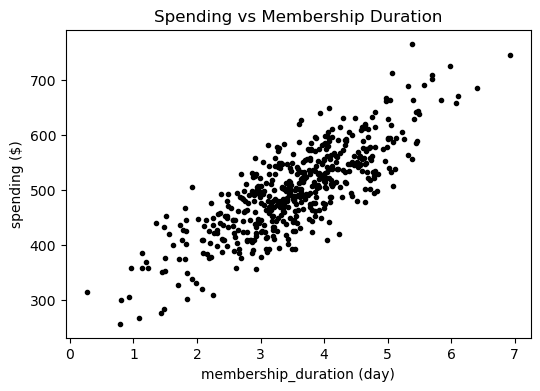

In [11]:
# creating scatter plot
predictor = 'membership_duration'
outcome = 'spending'

plt.figure(figsize=(6, 4))
plt.scatter(data[predictor],
            data[outcome],
            color='k',
            marker='.')

plt.xlabel(f'{predictor} (day)')
plt.ylabel(f'{outcome} ($)')
plt.title('Spending vs Membership Duration')
plt.show()

In [12]:
import statsmodels.formula.api as sm

model = sm.ols(f'{outcome} ~ {predictor}', data)
results = model.fit()
round(results.rsquared, 3)

0.655

This regression model with only one predictor, `membership_duration`, can explain 65% of the variation in the data.

The original sentence states that the regression model has an `r squared` of 0.65. `r squared` is a measure of how well the regression model fits the data. A value of 0.65 means that the model can explain 65% of the variation in the data.

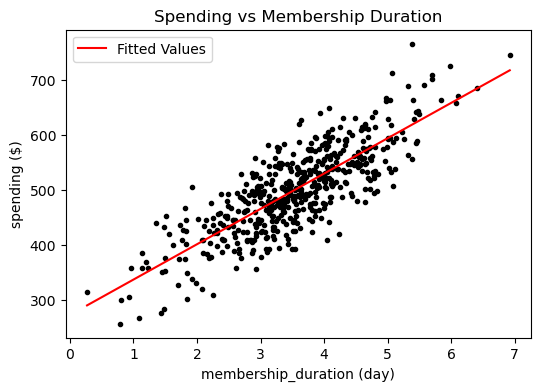

In [13]:
# creating scatter plot
predictor = 'membership_duration'
outcome = 'spending'

plt.figure(figsize=(6, 4))
plt.scatter(data[predictor],
            data[outcome],
            color='k',
            marker='.')

# creating fitted value
a_hat = results.params[0]
b_hat = results.params[1]
x_domain = np.linspace(np.min(data[predictor]),
                       np.max(data[predictor]),
                       len(data))
fitted_values = a_hat + b_hat * x_domain

# insert fitted line to scatter plot
plt.plot(x_domain,
         fitted_values,
         label='Fitted Values',
         color='r')

plt.xlabel(f'{predictor} (day)')
plt.ylabel(f'{outcome} ($)')
plt.title('Spending vs Membership Duration')
plt.legend()
plt.show()

In [14]:
print_coef(results)

,coef,std err
Intercept,272.3998,7.6750
membership_duration,64.2187,2.0903


$$ \text{spending} = 272 + 64\times\text{membership_duration}$$

$$ \text{spending} = 499 + 64 \times \text{(membership_duration - 4)}$$
    
So, the interpretation would be, that average `spending` of people with an average `membership_duration` is `$499`.

### 3.1.2. Residual plot

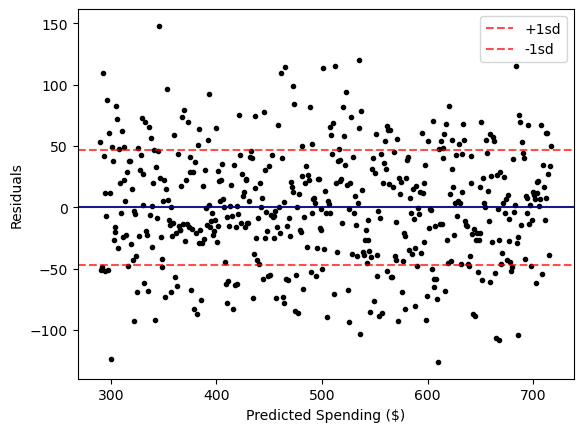

In [15]:
# fitted value
a_hat = results.params[0]
b_hat = results.params[1]
x_domain = np.linspace(np.min(data[predictor]),
                       np.max(data[predictor]),
                       len(data))
fitted_values = a_hat + b_hat * x_domain

# residual plot
rsd = np.sqrt(results.scale)
residual = results.resid

plt.scatter(fitted_values,
            residual,
            c='k',
            marker='.')
plt.axhline(y=0, c='navy', linestyle='-', alpha=0.9)
plt.axhline(y=rsd, c='r', linestyle='--', label='+1sd', alpha=0.7)
plt.axhline(y=-rsd, c='r', linestyle='--', label='-1sd', alpha=0.7)

plt.xlabel('Predicted Spending ($)')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### 3.1.3. Normality of Error Assumption

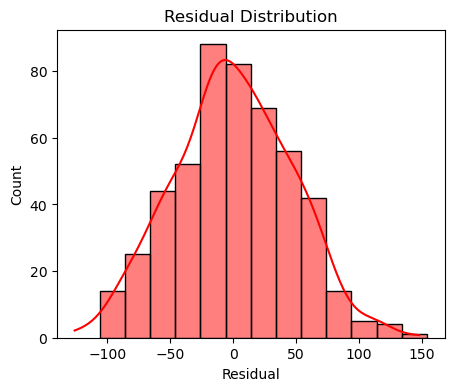

In [16]:
bin_size = 20
bins = np.arange(min(residual) + bin_size, max(residual) + bin_size, bin_size)

plt.figure(figsize=(5, 4))
sns.histplot(residual, kde=True, bins=bins, color='r')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

## 3.2. Regression with 2 predictors

In [17]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold

class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self, X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
    return (fold_train, fold_test)

### 3.2.1. Fitting Regression Model

In [18]:
# fitting model 2
# adding 1 more predictor to model (model 2)
x1 = 'membership_duration'
x2 = 'app_duration'
y = 'spending'

model_2 = sm.ols(f'{y} ~ {x1} + {x2}', data)
results_2 = model_2.fit()
print_coef(results_2)

,coef,std err
Intercept,-181.5310,15.4220
membership_duration,63.1173,1.2280
app_duration,37.9857,1.2342


### 3.2.2. Collinearity Checking

`membership_duration` and `app_duration` are nearly collinear because the standard error of the slope for the two variables is only slightly different. Therefore, it is necessary to check the visualization of the standard error.

In [19]:
def sampling(data, n_sample):
    '''
    Function to do repeatedly sample from the same data
    '''
    data_list = []
    for i in range(n_sample):
        data_sample = data.sample(n = len(data), replace = True)
        data_list.append(data_sample)
    return data_list

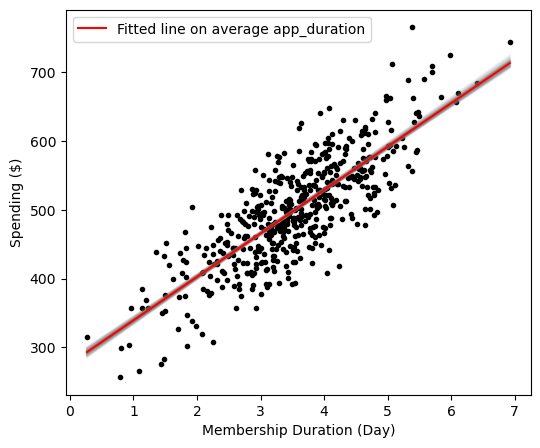

In [20]:
data_ = data
x1 = 'membership_duration'
x2 = 'app_duration'
y = 'spending'
n_sample = 100 # how many times the sample from `sampling` want to use

# Get samples from the same data using function that we've created above
data_new = sampling(data=data_, n_sample=n_sample)

plt.figure(figsize=(6, 5))
plt.scatter(data_[x1],
            data_[y],
            c='k',
            marker='.')

for x in range(n_sample):
    data_train = data_new[x]
    
    # fitting model
    model = sm.ols(f'{y} ~ {x1} + {x2}', data_train)
    results = model.fit()
    
    # store coef
    b0 = results.params.Intercept
    b1 = results.params[x1]
    b2 = results.params[x2]
    x_1 = np.linspace(np.min(data_[x1]), np.max(data_[x1]), len(data_))
    x_2 = data_[x2].mean() # this x2 using `app_duration` mean

    # fitted value
    fitted_value = b0 + (b1 * x_1) + (b2 * x_2)
    
    # plot fitted value into scatter plot
    plt.plot(x_1,
             fitted_value,
             c='grey',
             alpha=0.05,
             zorder=1)

# fitted line with original data
model = sm.ols(f'{y} ~ {x1} + {x2}', data_)
results = model.fit()

# store coef
b0 = results.params.Intercept
b1 = results.params[x1]
b2 = results.params[x2]
x_1 = np.linspace(np.min(data_[x1]), np.max(data_[x1]), len(data_))
x_2 = data_[x2].mean() # this x2 using `app_duration` mean

# fitted value with original data
fitted_value = b0 + (b1 * x_1) + (b2 * x_2)

# plot line
plt.plot(x_1,
         fitted_value,
         c='r',
         zorder=3,
         label='Fitted line on average app_duration')

plt.legend()
plt.xlabel('Membership Duration (Day)')
plt.ylabel('Spending ($)')
plt.show()

The shadow is wide in the viz, but `near collinearity` does not affect the regression line. So, we should avoid `perfect collinearity`.

### 3.2.3. Training Model with K-Fold

In [21]:
# adding 1 more predictor to model (model 2)
x1 = 'membership_duration'
x2 = 'app_duration'
y = 'spending'

_2pred_reg = StatsmodelsRegressor(sm.ols, f'{y} ~ {x1} + {x2}')

# k-fold splitter
kfold = KFold(n_splits=5,
              shuffle=True,
              random_state=123)

kfold_score = cross_val_score(estimator=_2pred_reg,
                              X=data,
                              y=data[y],
                              cv=kfold,
                              scoring='r2')
kfold_score = pd.DataFrame(data=kfold_score,
                           columns=['r_squared'])
kfold_score['Folds'] = [f'Folds {i+1}' for i in range(5)]
kfold_score

,r_squared,Folds
0,0.903205,Folds 1
1,0.843465,Folds 2
2,0.913554,Folds 3
3,0.844998,Folds 4
4,0.884426,Folds 5


In [22]:
# print average of 5 fold r-squared
kfold_score.r_squared.mean()

0.8779294982992883

In [23]:
# fitting model 2
model_2 = sm.ols(f'{y} ~ {x1} + {x2}', data)
results_2 = model_2.fit()
print_coef(results_2)

,coef,std err
Intercept,-181.5310,15.4220
membership_duration,63.1173,1.2280
app_duration,37.9857,1.2342


Because the intercept is negative and less meaningful, centering is performed on the predictor `membership_duration`.

In [24]:
# centering membership_duration
data['c_membership_duration'] = data.membership_duration - data.membership_duration.mean()

In [25]:
# adding 1 more predictor to model (model 2)
x1 = 'c_membership_duration'
x2 = 'app_duration'
y = 'spending'

_2pred_reg = StatsmodelsRegressor(sm.ols, f'{y} ~ {x1} + {x2}')

# k-fold splitter
kfold = KFold(n_splits=5,
              shuffle=True,
              random_state=123)

kfold_score = cross_val_score(estimator=_2pred_reg,
                              X=data,
                              y=data[y],
                              cv=kfold,
                              scoring='r2')
kfold_score = pd.DataFrame(data=kfold_score,
                           columns=['r_squared'])
kfold_score['Folds'] = [f'Folds {i+1}' for i in range(5)]
kfold_score

,r_squared,Folds
0,0.903205,Folds 1
1,0.843465,Folds 2
2,0.913554,Folds 3
3,0.844998,Folds 4
4,0.884426,Folds 5


In [26]:
# re-fitting model 2
model_2 = sm.ols(f'{y} ~ {x1} + {x2}', data)
results_2 = model_2.fit()
print_coef(results_2)

,coef,std err
Intercept,41.4915,14.9256
c_membership_duration,63.1173,1.2280
app_duration,37.9857,1.2342


$$ \text{spending} = 41 + 63 \times \text{(membership_duration - 4)} + 38 \times \text{app_duration}$$

##### Interpretation
**Membership Interpretation**
   
    If two people with the same app usage time compared, then the person with a membership duration that is 1 day longer than 4 days is predicted to have a spending that is $63 different.

**app_duration Interpretation**

    If we compare two people with the same membership duration, then the person who uses the app for 1 hour longer is predicted to have a spending that is $38 different.

**Intercepet Interpretation**

    If a person with a 4 days membership duration doesn't use the app, then their spending is predicted to be $41.

### 3.2.4. Residual plot from model 2

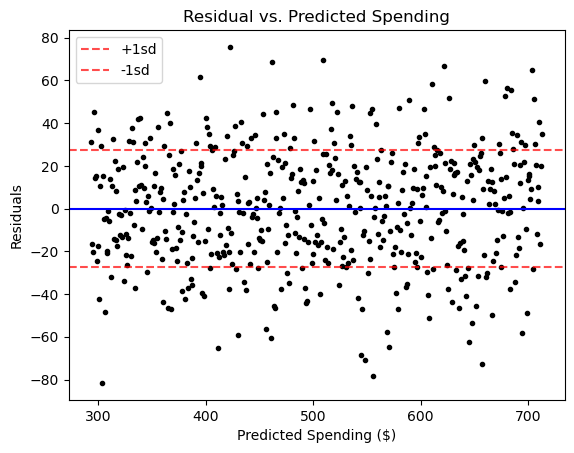

In [27]:
rsd = np.sqrt(results_2.scale)
residual = results_2.resid

plt.scatter(fitted_value,
            residual,
            c='k',
            marker='.')
plt.axhline(y=0, c='b', linestyle='-')
plt.axhline(y=rsd, c='r', linestyle='--', label='+1sd', alpha=0.7)
plt.axhline(y=-rsd, c='r', linestyle='--', label='-1sd', alpha=0.7)

plt.xlabel('Predicted Spending ($)')
plt.ylabel('Residuals')
plt.title('Residual vs. Predicted Spending')
plt.legend()
plt.show()

### 3.2.5. Normality of Error Assumption

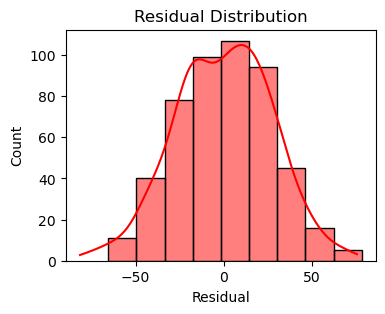

In [28]:
bin_size = 16
bins = np.arange(min(residual) + bin_size, max(residual) + bin_size, bin_size)

plt.figure(figsize=(4, 3))
sns.histplot(residual, kde=True, bins=bins, color='r')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()